# **scatter plot and compare all tissue coefs**

In [25]:
args = commandArgs(trailingOnly=TRUE)
# tissue = args[1]
# tissue_predOn = args[2]
# model_name = args[3]
# n_bootstrap=args[4]
# equiv_toLowest=args[5]
# exclude_triplet = args[6]
# exclude_CpG= args[7]


tissue = "skin"
tissue_predOn = "liver"
model_name = "model8"
n_bootstrap=0
equiv_toLowest=TRUE
exclude_triplet = FALSE
exclude_CpG= FALSE

tmp_file_path = "../../../"


model_desc_modify = ""
if (equiv_toLowest==TRUE){
    model_desc_modify = paste(model_desc_modify,"_equiv_toLowest",sep="")}
if (n_bootstrap==1000){
    model_desc_modify = paste(model_desc_modify,"_boot1k",sep="")
} else if (n_bootstrap==10000){
    model_desc_modify = paste(model_desc_modify,"_boot10k",sep="")
}
if (exclude_CpG==TRUE){
    model_desc_modify = paste(model_desc_modify,"_noCpG",sep="")}
if (exclude_triplet==TRUE){
    model_desc_modify = paste(model_desc_modify,"_noTriplets",sep="")}

library(dplyr)
library(stringr)
library(ggplot2)
library(patchwork)

#reading in data
if (tissue_predOn =="liver"){ #oif conditional as different files to compare to liver 
    tissue_coefs <- read.csv(paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_forLiver_coefDF",model_desc_modify,".csv",sep=""))
}else{tissue_coefs <- read.csv(paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_coefDF",model_desc_modify,".csv",sep=""))}
if (tissue=="liver"){
   tissue_predOn_coefs <- read.csv(paste(tmp_file_path,"data/",tissue_predOn,"/dataframes/",model_name,"/",tissue_predOn,"_forLiver_coefDF",model_desc_modify,".csv",sep=""))
}else{tissue_predOn_coefs <- read.csv(paste(tmp_file_path,"data/",tissue_predOn,"/dataframes/",model_name,"/",tissue_predOn,"_coefDF",model_desc_modify,".csv",sep=""))}


colnames(tissue_coefs) <- c("name",'tissue_est','tissue_stdErr','tissue_zVal','tissue_pVal','tissue_tStat')
colnames(tissue_predOn_coefs) <-c("name",'tissue_predOn_est','tissue_predOn_stdErr','tissue_predOn_zVal','tissue_predOn_pVal','tissue_predOn_tStat')

all_coefs <- merge(tissue_coefs,tissue_predOn_coefs,by="name")#for some reason the dim b/t germ and blood are different so need a merge... 

#create col that categorizes 
all_coefs<-all_coefs %>%
    mutate(type = case_when(        
        str_detect(name, 'percent') ~ 'sequence',
        str_detect(name, 'Chromosome') ~ 'sequence',
        str_detect(name, 'Repeats') ~ 'sequence',
        str_detect(name, 'site') ~ 'sequence',
        str_detect(name, 'annot') ~ 'sequence',
        str_detect(name, 'content') ~ 'sequence',
        str_detect(name, 'CpG') ~ 'sequence',
        
        str_detect(name, 'triplet') ~ 'triplet',
        
        str_detect(name, 'DNAse') ~ 'tissue_specific',
        str_detect(name, 'Transcription') ~ 'tissue_specific',
        str_detect(name, 'H3k') ~ 'tissue_specific',
        str_detect(name, 'methyl') ~ 'tissue_specific',
        
        str_detect(name, 'recomb') ~ 'global',
        str_detect(name, 'lamin') ~ 'global',
        str_detect(name, 'Replication') ~ 'global',
        str_detect(name, 'dist_rep') ~ 'global',
        
#         str_detect(name, 'Intercept') ~ '(intercept)',
    ))



all_sign_coefs <- filter(all_coefs[order(-all_coefs$tissue_est),],(tissue_pVal<0.05)|(tissue_predOn_pVal<0.05))


colors_ggplot <- c(sequence = "#7CAE00", triplet = "#C77CFF", global ='#F8766D', tissue_specific = '#00BFC4', intercept = "darkgrey")

#plotting
#  
#writing some infor on how wel they match to file 
error_output_file = paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,"_textOutput",model_desc_modify,".txt",sep="")
MAE = mean(abs(all_coefs$tissue_est - all_coefs$tissue_predOn_est),na.rm=TRUE)
string_to_print = paste("mean absolute error is",round(MAE,4),sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
fit<-lm(tissue_est~tissue_predOn_est,data=all_coefs)
string_to_print = paste("r-squared is",summary(fit)$r.squared,sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)





#plotting

p1<-ggplot(all_sign_coefs, aes(y = tissue_est, x = tissue_predOn_est,label=name)) +
    geom_point(aes(fill=type,color=type) )+
    theme_light()+
#     scale_y_continuous(breaks=seq(-0.75,1.75,0.75)) +
#     scale_x_continuous(breaks=seq(-0.75,1.75,0.75)) +
    geom_abline(intercept=0, slope=1, col="grey",linetype="dashed")+ #http://www.sthda.com/english/wiki/ggplot2-line-types-how-to-change-line-types-of-a-graph-in-r-software
    geom_abline(intercept=0, slope=0, col="cornflowerblue")+
    geom_vline(xintercept=0,col="cornflowerblue") + #http://www.sthda.com/english/wiki/ggplot2-add-straight-lines-to-a-plot-horizontal-vertical-and-regression-lines
    labs(
        x = paste(tissue_predOn," coefficient values",sep=""),
        y = paste(tissue," coefficient values",sep=""),
        color = "Predictor class"#https://stackoverflow.com/questions/14622421/how-to-change-legend-title-in-ggplot
        ) +
    theme(
    axis.text = element_text(size = 20, family = 'Helvetica', color = 'black'),
    axis.title = element_text(size = 20, family = 'Helvetica'),
    legend.title = element_text(size=12, family = 'Helvetica'),
    legend.text = element_text(size = 12, family = 'Helvetica')
    )  +
    scale_color_manual(values = colors_ggplot)+
    geom_text(hjust=0, vjust=0,aes(color=type),size=2)#https://stackoverflow.com/questions/15624656/label-points-in-geom-point
# ggsave(p1, paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,"_onlySignCoefs_label",model_desc_modify,".pdf",sep=""))
p2<-ggplot(all_sign_coefs, aes(y = tissue_est, x = tissue_predOn_est,label=name)) +
    geom_point(aes(fill=type,color=type) )+
    theme_light()+
#     scale_y_continuous(breaks=seq(-0.75,1.75,0.75)) +
#     scale_x_continuous(breaks=seq(-0.75,1.75,0.75)) +
    geom_abline(intercept=0, slope=1, col="grey",linetype="dashed")+ #http://www.sthda.com/english/wiki/ggplot2-line-types-how-to-change-line-types-of-a-graph-in-r-software
    geom_abline(intercept=0, slope=0, col="cornflowerblue")+
    geom_vline(xintercept=0,col="cornflowerblue") + #http://www.sthda.com/english/wiki/ggplot2-add-straight-lines-to-a-plot-horizontal-vertical-and-regression-lines
    labs(
        x = paste(tissue_predOn," coefficient values",sep=""),
        y = paste(tissue," coefficient values",sep=""),
        color = "Predictor class"#https://stackoverflow.com/questions/14622421/how-to-change-legend-title-in-ggplot
        ) +
    theme(
    axis.text = element_text(size = 20, family = 'Helvetica', color = 'black'),
    axis.title = element_text(size = 20, family = 'Helvetica'),
    legend.title = element_text(size=12, family = 'Helvetica'),
    legend.text = element_text(size = 12, family = 'Helvetica')
    )  +
    geom_pointrange(aes(ymin=tissue_est-tissue_stdErr, ymax=tissue_est+tissue_stdErr, color=type),alpha=0.4)+
    geom_pointrange(aes(xmin=tissue_predOn_est-tissue_predOn_stdErr, xmax=tissue_predOn_est+tissue_predOn_stdErr, color=type),alpha=0.4)+
    scale_color_manual(values = colors_ggplot)
# ggsave(p2,paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,"_onlySignCoefs",model_desc_modify,".pdf",sep=""))
p<-p1+p2
ggsave(plot = p, width = 18, height = 10, dpi = 200, filename =paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,"_onlySignCoefs",model_desc_modify,"_comb.pdf",sep=""))


MAE = mean(abs(all_sign_coefs$tissue_est - all_sign_coefs$tissue_predOn_est),na.rm=TRUE)
string_to_print = paste("mean absolute error is for sign coefs only ",round(MAE,4),sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
fit<-lm(tissue_est~tissue_predOn_est,data=all_sign_coefs)
string_to_print = paste("r-squared is for sign coefs only",summary(fit)$r.squared,sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

# **MODEL 5 COEF PLOT COMPS**

Saving 6.67 x 6.67 in image



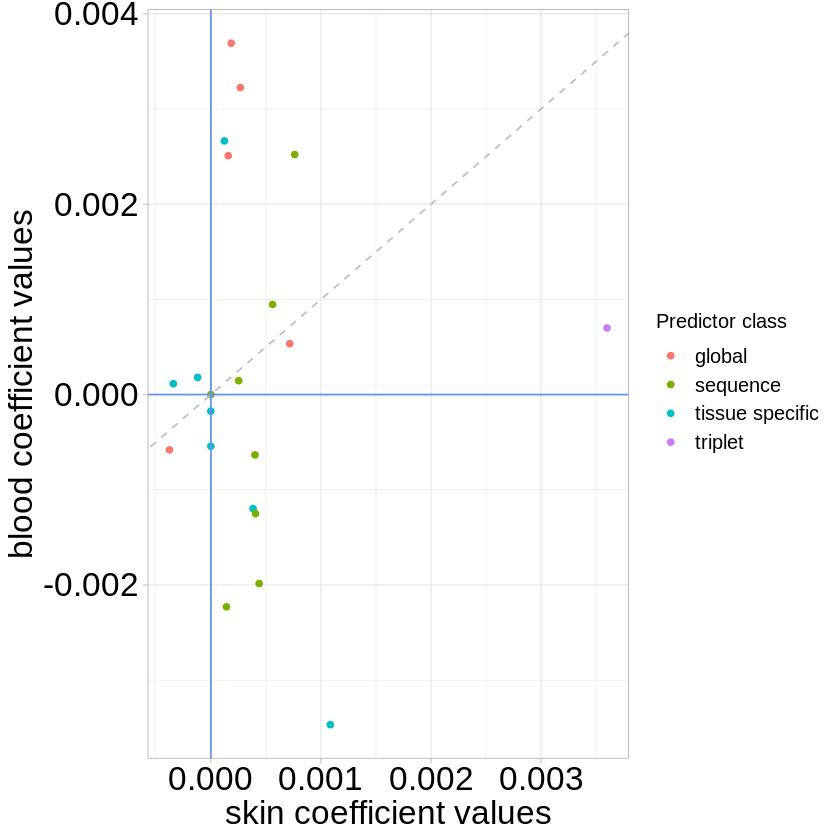

Saving 6.67 x 6.67 in image



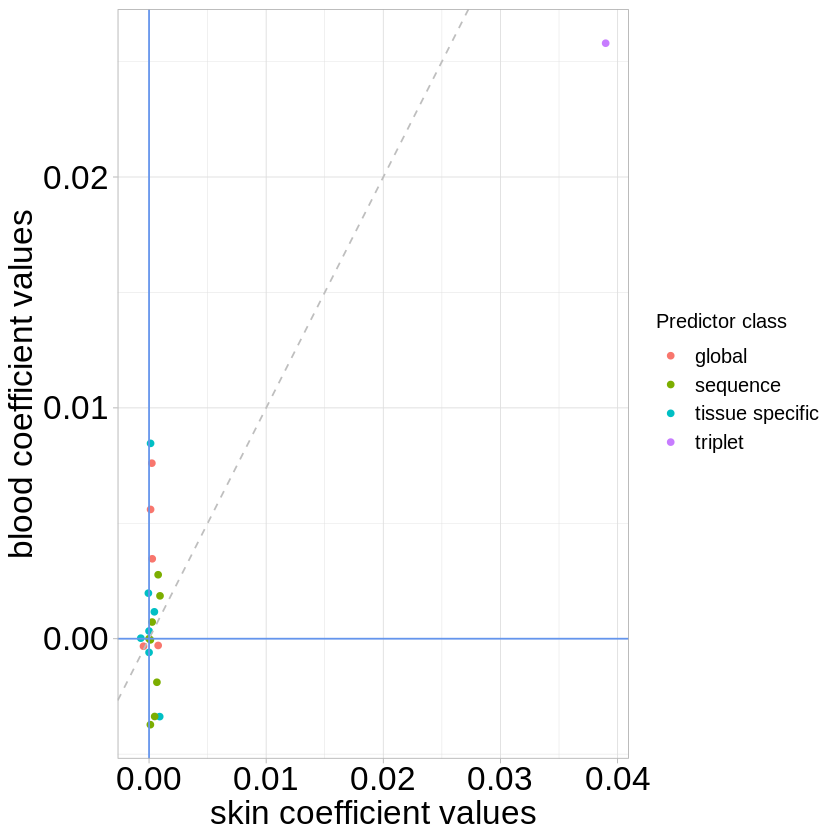

In [3]:
#### args = commandArgs(trailingOnly=TRUE)
# tissue = args[1]
# tissue_predOn = args[2]
# model_name = args[3]
tissue = "blood"
tissue_predOn = "skin"
model_name = "model5"
tmp_file_path = "../../../"


library(dplyr)
library(ggplot2)
library(stringr)

#reading in data
stopifnot(tissue != "liver")
stopifnot(tissue_predOn != "liver")
tissue_coefs <- read.csv(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/iterRemove_pred_effects.txt",sep=""))

tissue_predOn_coefs <- read.csv(paste(tmp_file_path,"analysis/",tissue_predOn,"/plots/",model_name,"/iterRemove_pred_effects.txt",sep=""))

colnames(tissue_coefs)<-c("name","tissue_accuracy","tissue_r_squared")
colnames(tissue_predOn_coefs)<-c("name","tissue_predOn_accuracy","tissue_predOn_r_squared")

all_coefs <- left_join(tissue_coefs,tissue_predOn_coefs,by = "name")


#create col that categorizes 
all_coefs<-all_coefs %>%
    mutate(type = case_when(        
        str_detect(name, 'percent') ~ 'sequence',
        str_detect(name, 'Chromosome') ~ 'sequence',
        str_detect(name, 'Repeats') ~ 'sequence',
        str_detect(name, 'site') ~ 'sequence',
        str_detect(name, 'annot') ~ 'sequence',
        str_detect(name, 'content') ~ 'sequence',
        
        str_detect(name, 'triplet') ~ 'triplet',
        
        str_detect(name, 'DNAse') ~ 'tissue specific',
        str_detect(name, 'Transcription') ~ 'tissue specific',
        str_detect(name, 'H3k') ~ 'tissue specific',
        
        str_detect(name, 'recomb') ~ 'global',
        str_detect(name, 'lamin') ~ 'global',
        str_detect(name, 'Replication') ~ 'global',
    ))


#plotting
ggplot(all_coefs, aes(y = tissue_accuracy, x = tissue_predOn_accuracy)) +
    geom_point(aes(color=type) )+
    theme_light()+
#     scale_y_continuous(breaks=seq(-0.75,1.75,0.75)) +
#     scale_x_continuous(breaks=seq(-0.75,1.75,0.75)) +
    geom_abline(intercept=0, slope=1, col="grey",linetype="dashed")+ #http://www.sthda.com/english/wiki/ggplot2-line-types-how-to-change-line-types-of-a-graph-in-r-software
    geom_abline(intercept=0, slope=0, col="cornflowerblue")+
    geom_vline(xintercept=0,col="cornflowerblue") + #http://www.sthda.com/english/wiki/ggplot2-add-straight-lines-to-a-plot-horizontal-vertical-and-regression-lines
    labs(
        x = paste(tissue_predOn," coefficient values",sep=""),
        y = paste(tissue," coefficient values",sep=""),
        color = "Predictor class"#https://stackoverflow.com/questions/14622421/how-to-change-legend-title-in-ggplot
        ) +
    theme(
    axis.text = element_text(size = 20, family = 'Helvetica', color = 'black'),
    axis.title = element_text(size = 20, family = 'Helvetica'),
    legend.title = element_text(size=12, family = 'Helvetica'),
    legend.text = element_text(size = 12, family = 'Helvetica')
    )   
ggsave(paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,"_accuracy.pdf",sep=""))

#plotting
ggplot(all_coefs, aes(y = tissue_r_squared, x = tissue_predOn_r_squared)) +
    geom_point(aes(color=type) )+
    theme_light()+
#     scale_y_continuous(breaks=seq(-0.75,1.75,0.75)) +
#     scale_x_continuous(breaks=seq(-0.75,1.75,0.75)) +
    geom_abline(intercept=0, slope=1, col="grey",linetype="dashed")+ #http://www.sthda.com/english/wiki/ggplot2-line-types-how-to-change-line-types-of-a-graph-in-r-software
    geom_abline(intercept=0, slope=0, col="cornflowerblue")+
    geom_vline(xintercept=0,col="cornflowerblue") + #http://www.sthda.com/english/wiki/ggplot2-add-straight-lines-to-a-plot-horizontal-vertical-and-regression-lines
    labs(
        x = paste(tissue_predOn," coefficient values",sep=""),
        y = paste(tissue," coefficient values",sep=""),
        color = "Predictor class"#https://stackoverflow.com/questions/14622421/how-to-change-legend-title-in-ggplot
        ) +
    theme(
    axis.text = element_text(size = 20, family = 'Helvetica', color = 'black'),
    axis.title = element_text(size = 20, family = 'Helvetica'),
    legend.title = element_text(size=12, family = 'Helvetica'),
    legend.text = element_text(size = 12, family = 'Helvetica')
    )   
ggsave(paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,"_rSquared.pdf",sep=""))

#writing some infor on how wel they match to file 
error_output_file = paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,"_textOutput.txt",sep="")

MAE = mean(abs(all_coefs$tissue_accuracy - all_coefs$tissue_predOn_accuracy),na.rm=TRUE)
string_to_print = paste("mean absolute error is",round(MAE,4),sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

fit<-lm(tissue_accuracy~tissue_predOn_accuracy,data=all_coefs)
string_to_print = paste("r-squared is",summary(fit)$r.squared,sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

# **EXTRA NOT IN SCRIPT--> get the fold coomp plot**

In [8]:
all_coefs <- all_coefs %>% 
    mutate(fold_change = tissue_coefs/tissue_predOn_coefs)  

all_ceofs <- all_coefs[order(all_coefs$fold_change),] 

head_all_coefs <- head(all_ceofs,n=10)
tail_all_coefs <- tail(all_ceofs,n=10)
fold_plotting <- rbind(head_all_coefs,tail_all_coefs)

posNeg_log10 <- function(number) {
    if (number > 0) {
         return(log10(number))
    } else {
         return(-log10(-number))
    }
}
fold_plotting$log10_chnage <- as.numeric(lapply(fold_plotting$fold_change, posNeg_log10))



Saving 6.67 x 6.67 in image



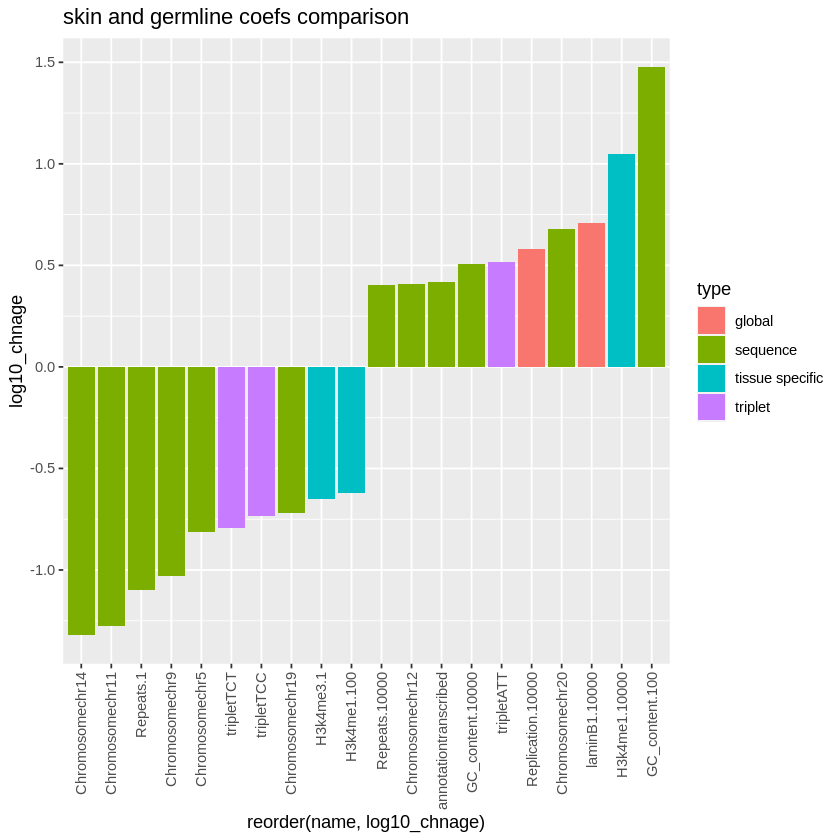

In [9]:
ggplot(data=fold_plotting,aes(x=reorder(name,log10_chnage),y=log10_chnage))+
    geom_bar(stat="identity",aes(fill=type))+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+#https://stackoverflow.com/questions/1330989/rotating-and-spacing-axis-labels-in-ggplot2
    ggtitle(paste(tissue,"and",tissue_predOn,"coefs comparison",sep=" "))
ggsave(paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefFoldChange_",tissue,"_on_",tissue_predOn,".pdf",sep=""))

NULL

Saving 6.67 x 6.67 in image



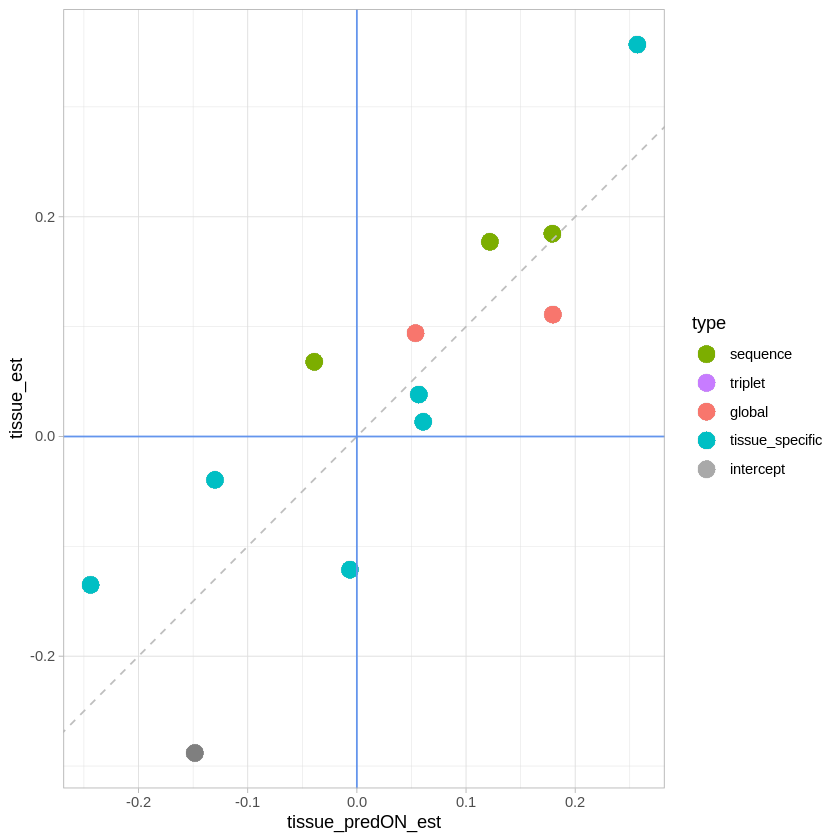

In [292]:
ggplot(all_sign_coefs, aes(x=tissue_predON_est, y=tissue_est, group=type)) +
    geom_point(size=5,shape=21,stroke=0.1,color="lightgrey",aes( fill=type,))+#http://www.sthda.com/english/wiki/ggplot2-point-shapes
    theme_light()+    
    geom_abline(intercept=0, slope=1, col="grey",linetype="dashed")+ #http://www.sthda.com/english/wiki/ggplot2-line-types-how-to-change-line-types-of-a-graph-in-r-software
    geom_abline(intercept=0, slope=0, col="cornflowerblue")+
    geom_vline(xintercept=0,col="cornflowerblue") +
    scale_shape_manual(values = c(21,21,21)) +     
    scale_fill_manual(values = colors_ggplot)
    labs(
        x = paste(tissue_predOn," coefficient values",sep=""),
        y = paste(tissue," coefficient values",sep=""),
        color = "Predictor class"#https://stackoverflow.com/questions/14622421/how-to-change-legend-title-in-ggplot
        ) +
    theme(
    axis.text = element_text(size = 20, family = 'Helvetica', color = 'black'),
    axis.title = element_text(size = 20, family = 'Helvetica'),
    legend.title = element_text(size=12, family = 'Helvetica'),
    legend.text = element_text(size = 12, family = 'Helvetica')
    )  +
    geom_pointrange(aes(ymin=tissue_quant025, ymax=tissue_quant975, color=type),alpha=0.4)+
    geom_pointrange(aes(xmin=tissue_predON_quant025, xmax=tissue_predON_quant975, color=type),alpha=0.4)
ggsave("test.pdf")


    
#     scale_y_continuous(breaks=seq(-0.75,1.75,0.75)) +
#     scale_x_continuous(breaks=seq(-0.75,1.75,0.75)) +
 #http://www.sthda.com/english/wiki/ggplot2-add-straight-lines-to-a-plot-horizontal-vertical-and-regression-lines




Warning message:
“Removed 1 rows containing missing values (geom_point).”


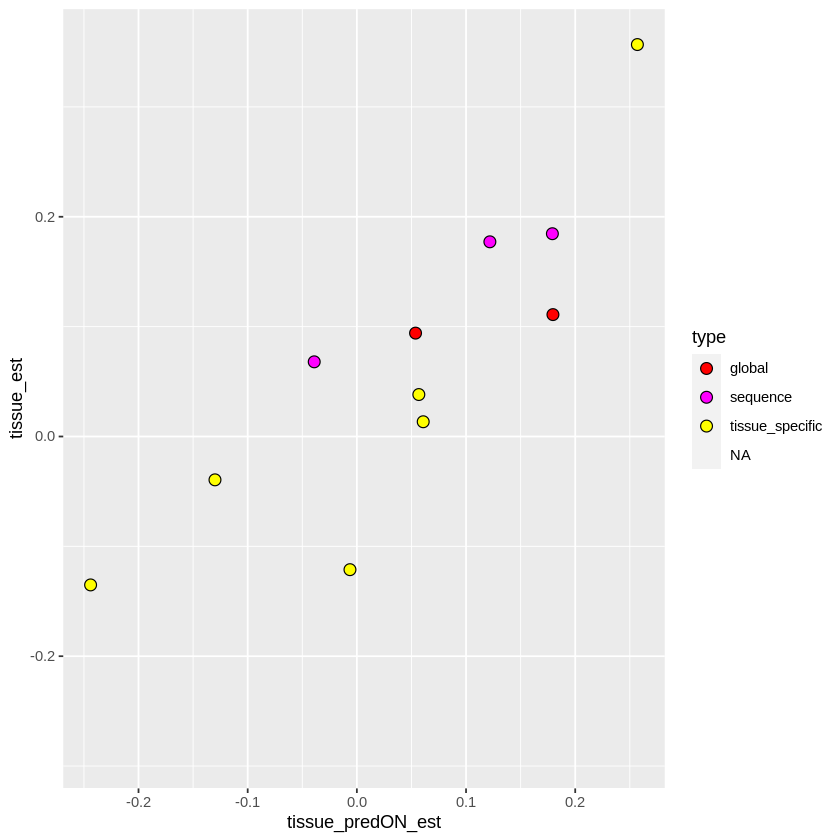

In [266]:
ggplot(all_sign_coefs, aes(y = tissue_est, x = tissue_predON_est,label=name,shape=type,fill=type)) +
      geom_point(size = 3) + 
      scale_shape_manual(values = c(21,21,21)) + 
      scale_fill_manual(values = c( "red", "magenta", "yellow"))